データ処理はsklearn, pandas, numpy, matplotlib.pyplot, seabornなど

訓練はtensorflow_decision_forestsを使う

GoogleColabを使わない場合はLinuxが必要、ローカルのＧＰＵ使用はcuDNN8.6.0とnvidia toolkit 11.8が望ましい

プロトタイプであるためコラムごとの最適化、データの水増しなどを一旦考慮しないようにする

スウ環境設備：CPU:i7-12700k GPU:RTX3080super
動作環境:WSL2上のUbuntu22--4, jupyter-lab 

In [310]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_decision_forests as tfdf
import datetime
current_directory = os.getcwd()
print(current_directory)

/mnt/f/python/kaggle/Linkingwritingprocess


In [311]:
# スウ環境用
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print("GPU Device:", device)

Num GPUs Available:  1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [312]:
# data loading
train_directory = os.path.join(current_directory, "train_logs.csv")
label_directory = os.path.join(current_directory, "train_scores.csv")
train_dataset = pd.read_csv(train_directory)
label_dataset = pd.read_csv(label_directory)
train_dataset

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


1.ざっくりデータを見たところ、idを使って合併させることができると思われる

2.event_idに意味がないので後に消去する

3.多少時系列データであるため言語モデルが通じるかもしれない？Transformer機構かRNN？

In [313]:
label_dataset

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


In [314]:
is_nan = train_dataset.isna().sum()
is_nan
# NaN値が入っていないので欠損値処理不要

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

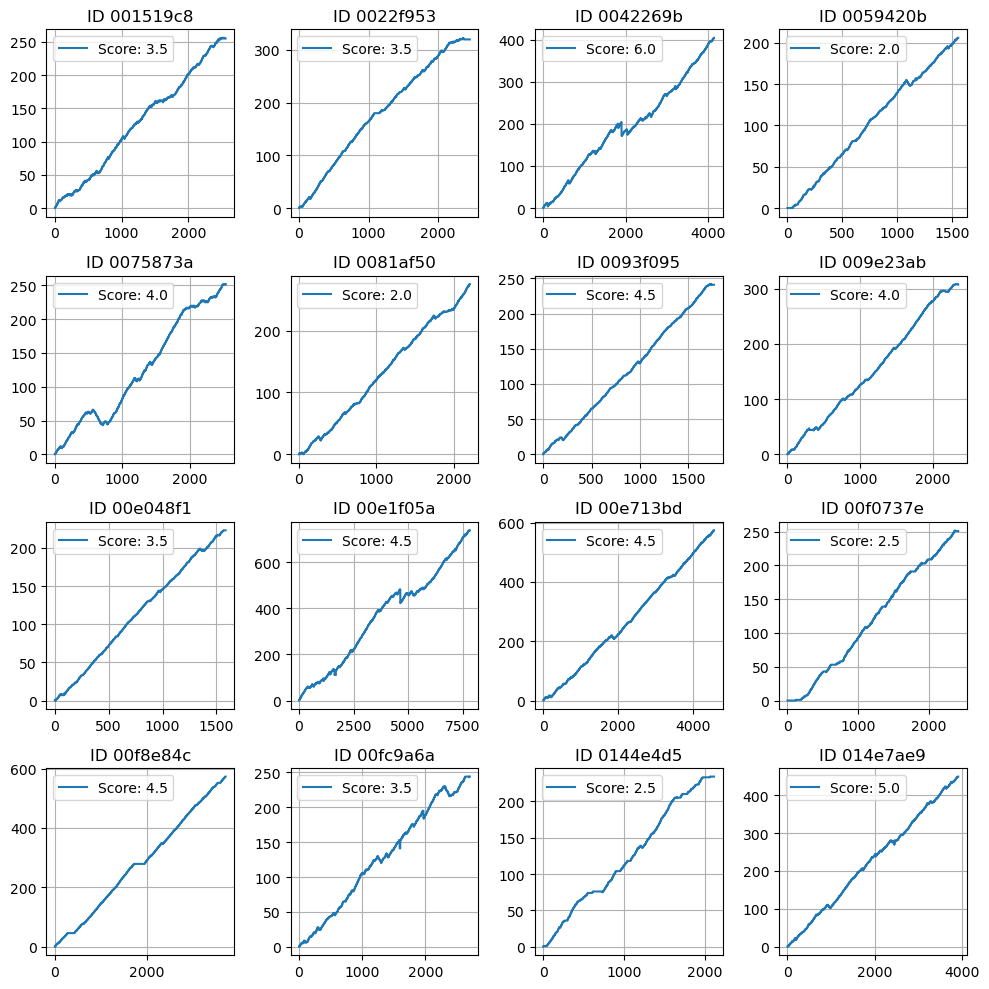

In [146]:
# 時系列データの形をプロットしてみる
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axes = axes.flatten()

for u, i in enumerate(ids[:16]):
    steps, pro_plot_df = len(train_dataset[train_dataset["id"]==i]), train_dataset[train_dataset["id"]==i]
    
    ax = axes[u]  # 現在のサブプロット
    ax.plot(list(range(1, steps+1)), pro_plot_df["word_count"], label=f'Score: {label_dataset[label_dataset["id"]==i]["score"].values[0]}')
    ax.grid()
    ax.legend()
    ax.set_title(f'ID {i}')

plt.tight_layout()
plt.show()

振動が強い文章が丁寧に修正されているため点数高い傾向がある？→絶対ではないが、やや相関性ある
<h4>従って、一次関数でシミュレートし、関数からのずれを学習データとして入力することが可能かもしれない  Δ　試したけど→否決します</h4>

相関性はあるけど、feature_engineeringの方法がだめだった

In [315]:
# 時系列データであるため直接使えないかもしれない？
# 字数、時間、時間/字数、leftclik, rightclikの数、一次関数でシミュレートした場合の偏差（平均二乗誤差）などを取り出してたらしいデータセットにしないと上手くいかない気がする。
# 言語モデルも可能かもしれないが、めんどくなりそう

# 従って、down_event, up_eventの中のユニークデータを考察してみる
sum(train_dataset["down_event"] == train_dataset["up_event"]) #マウスかキーボードを押したときと離す時発生するイベントがほぼ全部同じだが、逆に同じでない時は何があった？

8405364

In [316]:
train_dataset[train_dataset["down_event"] != train_dataset["up_event"]] #あんまり意味なさそうだから無視する

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5115,0042269b,105,104507,104617,110,Replace,q,m,qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq...,1,4
5232,0042269b,222,158578,158638,60,Replace,q,i,qqqqqqq => q,15,14
6276,0042269b,1266,473329,473439,110,Replace,q,o,qqq qq qqq qqqqqqq qqqqqq qqqq qq => q,194,128
6825,0042269b,1815,641821,641920,99,Replace,q,t,qqq qqqqq qq qqqqqqqq qqqq qqq qqqqqqq qq qqqq...,529,190
8223,0042269b,3213,1410198,1410293,95,Replace,q,a,qqqqqqq qqqqqqqqq qqqq qqq qq qqqq qqq qqqqqqq...,1539,282
...,...,...,...,...,...,...,...,...,...,...,...
8323360,fde20dd8,2019,495093,495205,112,Replace,q,i,qqqq => q,530,167
8328686,fde20dd8,7345,1760415,1760572,157,Replace,q,y,qq qqq qqq'q qqqqq qqqqqq qq qqq qqqqqqq => q,3218,700
8378372,ff90a677,29,50477,50647,170,Nonproduction,a,A,NoChange,18,4
8378374,ff90a677,31,50703,50837,134,Replace,q,i,q qq qqqqqqq qqqq => q,1,1


In [317]:
activity_columns = train_dataset["activity"].unique()
# このMove　Fromって要はコピペですね。コピペが多いと点数低いのでは？と思うので、'Nonproduction', 'Input', 'Remove/Cut', 'Replace', 'copyandpaste'の数でまとめてそれぞれ新しいコラム
# を作るのはどう？
print(activity_columns)

['Nonproduction' 'Input' 'Remove/Cut' 'Replace'
 'Move From [284, 292] To [282, 290]' 'Move From [287, 289] To [285, 287]'
 'Move From [460, 461] To [465, 466]' 'Paste'
 'Move From [905, 1314] To [907, 1316]'
 'Move From [565, 743] To [669, 847]' 'Move From [669, 847] To [565, 743]'
 'Move From [1041, 1121] To [1496, 1576]'
 'Move From [1455, 1557] To [1323, 1425]'
 'Move From [2268, 2275] To [2247, 2254]'
 'Move From [213, 302] To [902, 991]' 'Move From [0, 158] To [234, 392]'
 'Move From [460, 465] To [925, 930]' 'Move From [810, 906] To [816, 912]'
 'Move From [186, 187] To [184, 185]' 'Move From [140, 272] To [299, 431]'
 'Move From [114, 140] To [272, 298]'
 'Move From [1386, 1450] To [1445, 1509]'
 'Move From [442, 524] To [296, 378]' 'Move From [408, 414] To [390, 396]'
 'Move From [1144, 1147] To [1142, 1145]'
 'Move From [218, 220] To [206, 208]' 'Move From [164, 165] To [153, 154]'
 'Move From [623, 632] To [624, 633]'
 'Move From [747, 960] To [1041, 1254]'
 'Move From [274,

In [318]:
print(sum(train_dataset["text_change"]=="NoChange"))
# text_changeもほぼNoChangeで埋まっている

703851


In [319]:
len(train_dataset["text_change"].unique())
#　ユニーク操作が多い。これは各自独自のコピペなどの操作を行ってると考えられる。
# ここでは一旦NoChangeとNoChange以外でCountしてみるが、仮説として長い文字列をコンパクト化：qqqqqqqqq→qのようにすることは高いパフォーマンスに繋がるかもしれない。従って、各操作において
# 符号の左側のqと右側のqの比例、あるいは書き換えの数をカウントして新しいfeatureにすると良いかもしれない

4111

In [320]:
text_change_columns = train_dataset["text_change"].unique()

#置き換えを行うが、将来的にはこれより高度なfeature_engineeringが望ましい
train_dataset.loc[~train_dataset['text_change'].isin([text_change_columns[0]]), 'text_change'] = 'Changed'
text_change_columns = train_dataset["text_change"].unique()

In [321]:
# feature engineering
start_time = datetime.datetime.now()

ids = train_dataset["id"].unique()

words = train_dataset.groupby('id')['word_count'].last().reset_index()
time = train_dataset.groupby('id')['down_time'].last().reset_index()
time_per_word = time.copy()
time_per_word['time_per_word'] = time['down_time'] / words['word_count']
time_per_word = time_per_word.drop(columns=["down_time"])
    
words = words.rename(columns={'word_count': 'words'})
time  = time.rename(columns={'down_time': 'time'})

# このMove Fromxxxを全部MoveFromに変える
train_dataset.loc[~train_dataset['activity'].isin(activity_columns[:4]), 'activity'] = 'MoveFrom' 

# カテゴリ変数の数を新しいコラムに入れた新しいtabularを作る
activity_count = train_dataset.groupby('id')['activity'].value_counts().unstack(fill_value=0).reset_index()
# down_eventとup_eventに対しても同じことをやってみるが、ほぼ一緒なので片方を取る
down_event_count = train_dataset.groupby("id")["down_event"].value_counts().unstack(fill_value=0).reset_index()
text_change_count = train_dataset.groupby("id")["text_change"].value_counts().unstack(fill_value=0).reset_index()
# action_timeとcursor_positionに関して、まだ方法見つかってないし、もう寝る時間で、とりあえずmeanを使う
action_time = train_dataset.groupby("id")["action_time"].mean().reset_index()
cursor_position = train_dataset.groupby("id")["cursor_position"].mean().reset_index()

#マージして最終データを整える
train_ds = train_dataset.drop_duplicates(subset='id')[['id']].reset_index(drop=True)
train_ds = train_ds.merge(down_event_count, on='id', how='right')
train_ds = train_ds.merge(text_change_count, on='id', how='right')
train_ds = train_ds.merge(action_time, on='id', how='right')
train_ds = train_ds.merge(cursor_position, on='id', how='right')
train_ds = train_ds.merge(label_dataset, on='id', how='right')
# labelも忘れずに、TFDFは最後のコラムを自動的にコラム扱いする

end_time = datetime.datetime.now()
print(abs(start_time - end_time))

0:00:03.808018


時系列データプロットでの仮説を検証する
この部分で14分時間かかったので処理後のデータを保存した、みんなが検証する時はそのままこのセルではなく

mse_hypothesis = pd.read_csv("mse_hypothesis.csv")

で読み込んで次のセルに飛ぶと良い

In [193]:
from sklearn.linear_model import LinearRegression
# このステップは時間がかかるが、実際どれだけ役に立つのかはまだわからない、tfdfの後重要度を出力させてみて、必要な場合は代替案を考えるべき
mse_hypothesis = pd.DataFrame(columns=['id', "intercept", 'mse'])

start_time = datetime.datetime.now()
n = 0
for i in ids:
    n = 1 + n
    if n%100 == 0:
        print("loop:", n)
    steps, col = len(train_dataset[train_dataset["id"]==i]), train_dataset[train_dataset["id"]==i]
    x = np.array(list(range(1, steps+1)))
    y = np.array(col["word_count"])
    
    reg = LinearRegression().fit(x.reshape(-1, 1), y)
    
    slope = reg.coef_[0] #このslopeは各ステップ書く文字数に関連する
    intercept = reg.intercept_

    predicted_y = slope * x + intercept
    residuals = y - predicted_y
    mse = np.mean(residuals**2)
    new_col = pd.DataFrame({'id': [i], 'intercept': [intercept], 'mse': [mse]})
    mse_hypothesis = pd.concat([mse_hypothesis, new_col], axis=0)
    
end_time = datetime.datetime.now()
print(abs(start_time - end_time))

loop: 100
loop: 200
loop: 300
loop: 400
loop: 500
loop: 600
loop: 700
loop: 800
loop: 900
loop: 1000
loop: 1100
loop: 1200
loop: 1300
loop: 1400
loop: 1500
loop: 1600
loop: 1700
loop: 1800
loop: 1900
loop: 2000
loop: 2100
loop: 2200
loop: 2300
loop: 2400
0:14:34.758730


In [194]:
train_ds = train_ds.merge(mse_hypothesis, on='id', how='right')

In [322]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [323]:
import re
patterns = [r'\?', r'(%)', r',']  # 置き換えたいパターンをここに追加
replacements = ['question_mark', 'percentage_mark', 'comma']  # 対応する置き換え文字列をここに追加
# コラム名を置き換え
df = train_ds.copy()
for i in range(len(patterns)):
    df.columns = [re.sub(patterns[i], replacements[i], col) for col in df.columns]

In [324]:
train_ds_newnames.columns

Index(['id', '!', '"', '#', '$', '%', '&', ''', '(', ')',
       ...
       'Ë', 'â', 'ä', 'Changed', 'NoChange', 'action_time',
       'cursor_position', 'score', 'intercept', 'mse'],
      dtype='object', length=139)

In [325]:
# データ転換（pytorchでデータをtensorに転換するようなイメージ）
# ブラックボックスのようなデータになるが。。規格化とかも自動的に行われる
features = df.columns
train_ds_tfdf = tfdf.keras.pd_dataframe_to_tf_dataset(df[features[1:]], label="score", task=tfdf.keras.Task.REGRESSION, fix_feature_names=False)

In [326]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)

tuner.choice("num_trees", [300, 310, 340 ])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [15, 16, 18])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [256, 340])

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)
model.compile(metrics=["rmse"])
model.fit(x=train_ds_tfdf)

Use /tmp/tmpcatzb572 as temporary training directory
Reading training dataset...


[WARNING 23-10-22 07:03:09.8784 JST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-22 07:03:09.8785 JST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-22 07:03:09.8785 JST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.426234. Found 2471 examples.
Training model...
Model trained in 0:00:03.178638
Compiling model...


[INFO 23-10-22 07:03:14.4949 JST kernel.cc:1243] Loading model from path /tmp/tmpcatzb572/model/ with prefix 4f25ceedd81948ce
[INFO 23-10-22 07:03:14.4972 JST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-22 07:03:14.4972 JST kernel.cc:1075] Use fast generic engine


Model compiled.


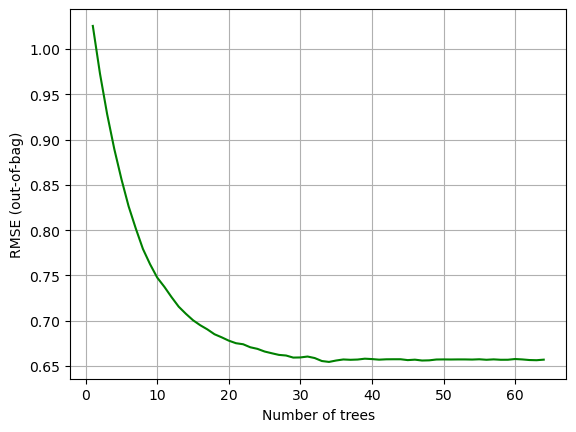

In [327]:
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs ], [log.evaluation.rmse for log in logs ], color="g")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.grid(True)
plt.show()

In [ ]:
# print(model.summary())

普通のRandomForestModelの方がRMSE低かったけど正直パフォーマンスが良くない

scikitlearnでのXGBoostなどのコードを追加して頂けると助かる

ほかのfeature engineering手法の提案もお願いします。

In [333]:
tuner = tfdf.tuner.RandomSearch(num_trials=30)

# Hyper-parameters to optimize.
tuner.choice("max_depth", [16,17,18])
tuner.choice("num_trees", [320,330,340])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [256, -1])

model = tfdf.keras.RandomForestModel(tuner=tuner, task=tfdf.keras.Task.REGRESSION)
model.compile("rmse")
model.fit(x = train_ds_tfdf)

Use /tmp/tmpx6ah_d7p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.920972. Found 2471 examples.
Training model...
Model trained in 0:00:24.183514


[INFO 23-10-22 07:06:51.1719 JST kernel.cc:1243] Loading model from path /tmp/tmpx6ah_d7p/model/ with prefix 224e1629876a436f
[INFO 23-10-22 07:06:51.3516 JST decision_forest.cc:660] Model loaded with 330 root(s), 236448 node(s), and 77 input feature(s).
[INFO 23-10-22 07:06:51.3516 JST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-10-22 07:06:51.3516 JST kernel.cc:1075] Use fast generic engine


Compiling model...
Model compiled.


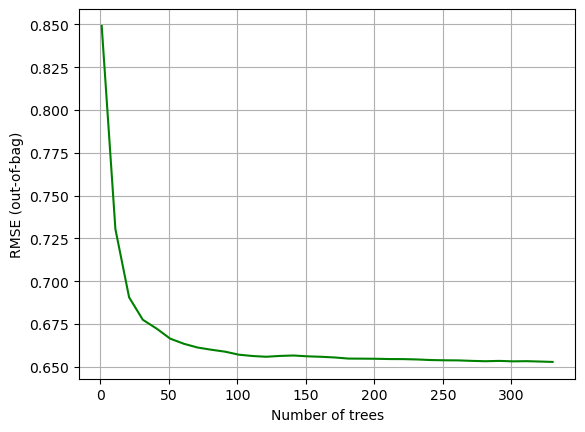

In [334]:
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs ], [log.evaluation.rmse for log in logs ], color="g")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.grid(True)
plt.show()

In [336]:
# print(model.summary())

In [339]:
# 最終的に0.652ぐらいのRMSEがtrain_dsで出した。action_time, cursor_position, NoChange（qqqq→q）のようなデータのfeature_engineering, よろしくお願いします
train_ds

,id,!,"""",#,$,%,&,',(,),...,Ä±,Å,Ë,â,ä,Changed,NoChange,action_time,cursor_position,score
0,001519c8,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,2437,120,116.246774,711.163473,3.5
1,0022f953,0,6,0,0,0,0,3,0,0,...,0,0,0,0,0,2200,254,112.221271,776.205786,3.5
2,0042269b,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,3961,175,101.837766,731.611702,6.0
3,0059420b,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1457,99,121.848329,542.537275,2.0
4,0075873a,0,0,0,0,0,0,17,0,0,...,0,0,0,0,0,2459,72,123.943896,600.050968,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,0,4,0,0,0,0,7,0,0,...,0,0,0,0,0,4550,189,105.437856,774.000633,3.5
2467,ffbef7e5,0,0,0,0,0,0,8,0,0,...,0,0,0,0,0,2456,148,82.266129,1022.078725,4.0
2468,ffccd6fd,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2937,126,75.605615,1309.085537,1.5
2469,ffec5b38,0,6,0,0,0,0,4,0,0,...,0,0,0,0,0,3171,71,89.277915,1192.640962,5.0
